# pyWavelet Snow Radar Processor

In [11]:
#pyWavelet modules
from pyWavelet import snowradar, picklayers

#Python stdlib
import os
import datetime
import time

#Community packages
import numpy as np
import matplotlib.pyplot as plt

In [12]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [17]:
#radar_file = "./data/sr/Data_20160419_04_010.mat"
#radar_file = "./data/eureka/sr/Data_20160419_04_025.mat"
#radar_file = "./data/sr/Data_20160420_02_090.mat"
#radar_file = "E:/OIB/snowradar/CSARP_deconv/20170310_01/Data_20170310_01_088.mat"
#radar_file = "E:/OIB/snowradar/CSARP_deconv/Data_20160419_05_005.mat"
#radar_file = "./data/sr/Data_20160420_02_090.mat"
radar_file = "./data/awi/Data_20170410_01_006.mat"


radar_dat = snowradar.OIB(radar_file, l_case='full')

Processing: ./data/awi/Data_20170410_01_006.mat



TypeError: unsupported operand type(s) for -: 'h5py.h5r.Reference' and 'h5py.h5r.Reference'

Convert the radar's GPS time to UTC and account for leap seconds

In [ ]:
example_date = datetime.datetime.utcfromtimestamp(radar_dat.time_utc[0])
print(example_date)

In [15]:
#radar_dat.decompress_data()
radar_sub = radar_dat.data_radar

#radar_sub = radar_dat.data_radar*5e10
#radar_sub = radar_dat.data_radar #*50000000000


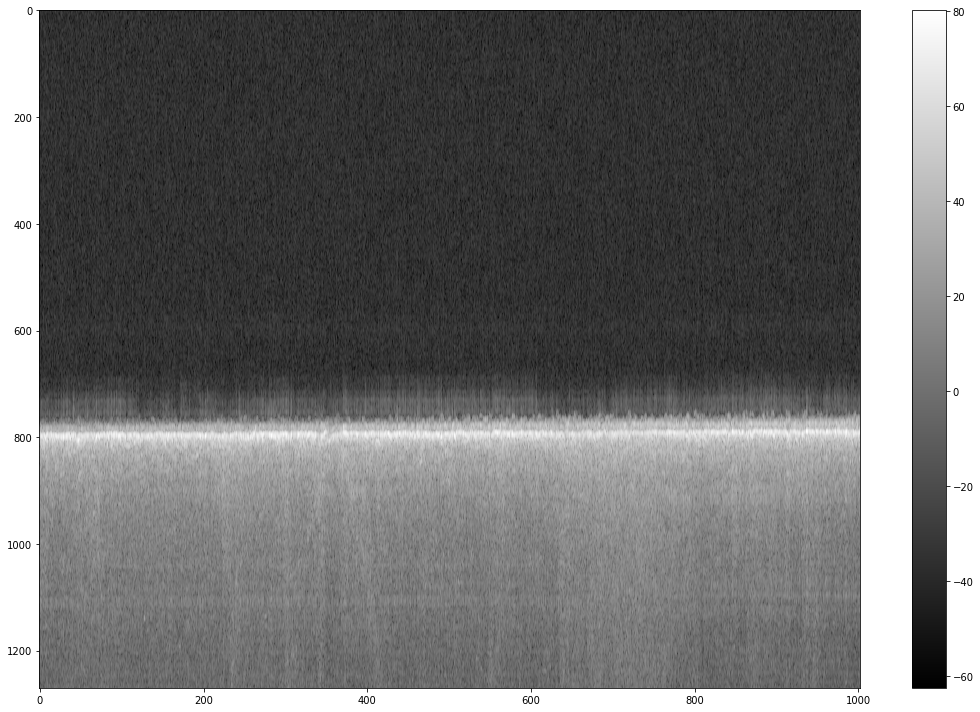

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
im = ax.imshow(20 * np.log10(radar_sub), cmap="gist_gray")
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)
fig.tight_layout();

### Signals stuff

In [9]:
oversample_num = 1000
num_nyquist_ts = 100
nyquist_sf = 2*radar_dat.bandwidth
fs = nyquist_sf *oversample_num 
time_step = 1/fs 
max_time  = num_nyquist_ts*oversample_num*time_step
time_vect = np.arange(-max_time,max_time,time_step)

In [10]:
radar_dat.calcpulsewidth()
print(radar_dat.epw)
print(radar_dat.n2n)

0.028389437310606055
0.075697595645


### This applies the picklayer function to every trace
TODO: Multi thread and bake into snowradar class

In [13]:
l_as, l_si = np.apply_along_axis(
    picklayers.picklayers, 
    0, 
    radar_sub,
    radar_dat.n2n,
    radar_dat.dfr,
    n_snow
)

In [14]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow

# Retrieval output

Max along-track resolution
Mean depth (m): -1.8901444495587252
StDev of  depth (m): 0.4316314788228353

5-bin averaged along-track 
Mean snow depth (m): -1.8899558558228724
StDev of snow depth (m): 0.4046075974571886


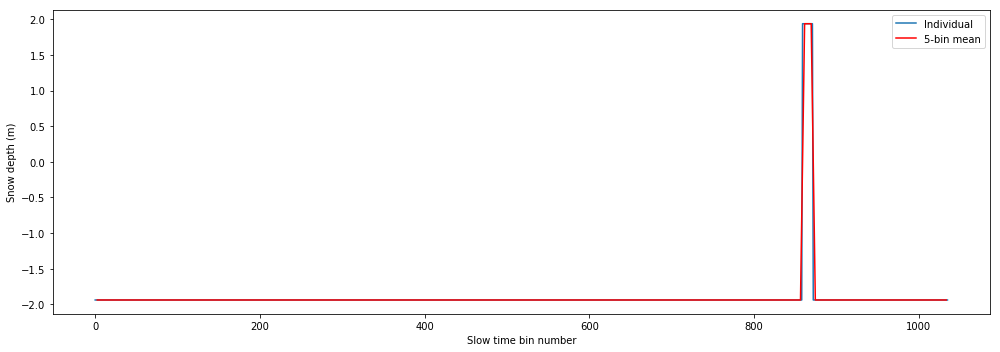

In [15]:
N = 5
snow_depth_rollin = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)
print("Max along-track resolution")
print("Mean depth (m):", np.mean(snow_depth))
print("StDev of  depth (m):", np.std(snow_depth))
print("\n5-bin averaged along-track ")
print("Mean snow depth (m):", np.mean(snow_depth_rollin))
print("StDev of snow depth (m):", np.std(snow_depth_rollin))

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(snow_depth)
#ax.plot(np.arange(0, len(snow_depth_rollin)),snow_depth_rollin, color='r')
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')

#ax.plot(l_as, color='b')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
fig.tight_layout();

#fig.savefig('20170310_01_088_Depth.pdf')

(array([1015.,    0.,    0.,    0.,    0.,    2.,    0.,    0.,    0.,
           0.,    2.,    0.,    0.,    0.,    0.,    2.,    0.,    0.,
           0.,    0.,    2.,    0.,    0.,    0.,    9.]),
 array([-1.93880163, -1.7836975 , -1.62859337, -1.47348924, -1.31838511,
        -1.16328098, -1.00817685, -0.85307272, -0.69796859, -0.54286446,
        -0.38776033, -0.2326562 , -0.07755207,  0.07755207,  0.2326562 ,
         0.38776033,  0.54286446,  0.69796859,  0.85307272,  1.00817685,
         1.16328098,  1.31838511,  1.47348924,  1.62859337,  1.7836975 ,
         1.93880163]),
 <a list of 25 Patch objects>)

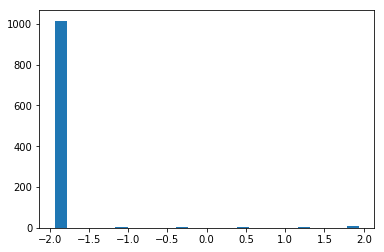

In [16]:
plt.hist(snow_depth_rollin, bins=25)

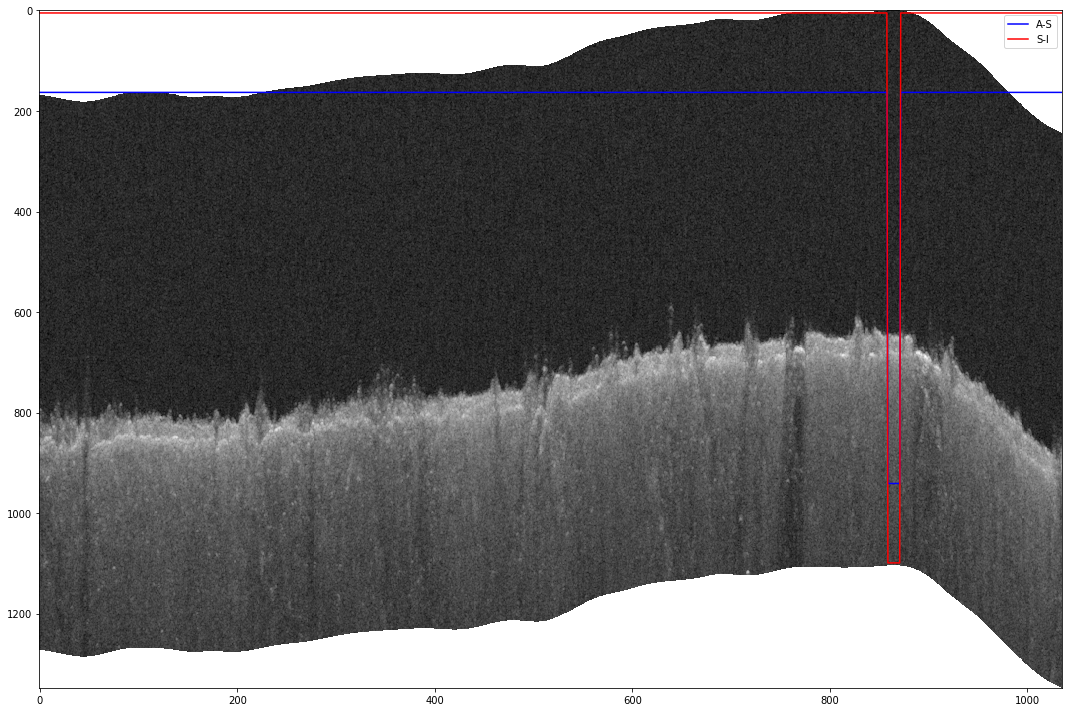

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(20 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray")
ax.plot(l_as, color='b')
ax.plot(l_si, color='r')
#ax.set_ylim([1000, 500])
ax.legend(["A-S","S-I"],loc="upper right")

ax.set_aspect('auto')
fig.tight_layout();

#fig.savefig('20170310_01_088_Picks.pdf')

120


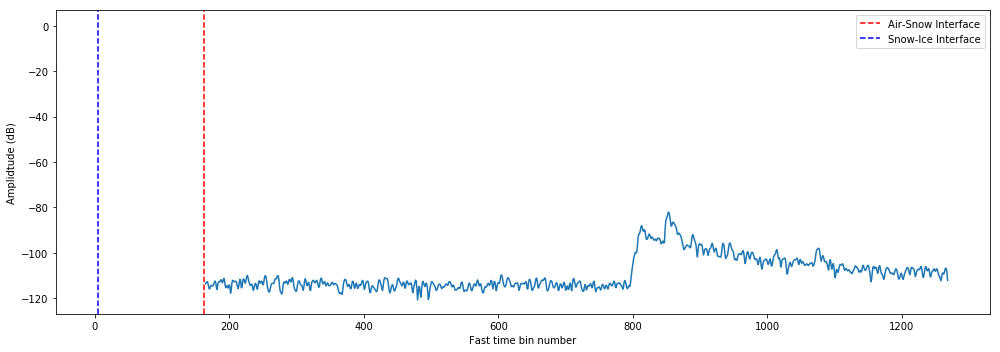

In [18]:
col_idx = np.random.randint(0, radar_sub.shape[1])
print(col_idx)
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(data_col)
ax.plot(10*np.log10(radar_sub[:,col_idx]), label=None)
#ax.plot(radar_sub[:,col_idx], label=None)

# Air-Snow picked interface
ax.vlines(l_as[col_idx], 0, 1, label='Air-Snow Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(l_si[col_idx], 0, 1, label='Snow-Ice Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right")
#ax.set_xlim([ymin, ymax])
fig.tight_layout();

#fig.savefig('20170310_01_088_AScope_Raw.pdf')